# Latent Posterior Inference (Feature Extraction)

**Definition:** Latent posterior inference computes the conditional distribution $p(z \mid x)$ of latent variables $z$ given observed data $x$. This posterior quantifies which latent codes likely generated $x$ and how uncertain that inference is.

**Toy linear-Gaussian setting (closed-form posterior):**

Generative model:
$ x = W z + b + \varepsilon $,  
where $ z \sim \mathcal{N}(0, I) $ (prior) and $ \varepsilon \sim \mathcal{N}(0, \sigma^2 I) $ (observation noise).

**Likelihood:** $ p(x \mid z) = \mathcal{N}(x; W z + b, \sigma^2 I) $  
**Prior:** $ p(z) = \mathcal{N}(z; 0, I) $

Because prior and likelihood are Gaussian and $W$ is linear, the posterior is Gaussian:

$ p(z \mid x) = \mathcal{N}\big(z; \mu_{\text{post}}, \Sigma_{\text{post}}\big) $

with analytic forms:

$ \Sigma_{\text{post}} = \left(I + \frac{1}{\sigma^2} W^\top W \right)^{-1} $

$ \mu_{\text{post}} = \Sigma_{\text{post}} \frac{1}{\sigma^2} W^\top (x - b) $

**Intuition:** directions where $W^\top W$ is large (data informative) yield smaller posterior variance; posterior mean is a linear projection of the whitened residual $(x-b)$ into latent space.

We will:
1. Compute $ \Sigma_{\text{post}} $ and $ \mu_{\text{post}} $ step-by-step and print intermediate results.  
2. Visualize prior and posterior in 2D and 3D (ellipses / ellipsoids, samples, reconstructions).  
3. Train a tiny encoder (linear regression) to predict $ \mu_{\text{post}} $ (amortized inference) and compare.


In [1]:
# Cell 2 — Imports and helper utilities
# Run this cell first

from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

np.random.seed(0)

def plot_cov_ellipse(ax, mu, cov, nstd=2.0, edgecolor='k', label=None):
    """Plot 2D covariance ellipse on ax."""
    cov = np.array(cov)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    angle = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=mu, width=width, height=height, angle=angle,
                  edgecolor=edgecolor, facecolor='none', lw=2)
    if label: ell.set_label(label)
    ax.add_patch(ell)

def plot_cov_ellipsoid_wireframe(ax, mu, cov, nstd=2.0, color='C0', alpha=0.6):
    """Plot 3D covariance ellipsoid wireframe for cov centered at mu."""
    u, s, vh = np.linalg.svd(cov)
    radii = nstd * np.sqrt(s)
    u_angles = np.linspace(0.0, 2.0*np.pi, 40)
    v_angles = np.linspace(0.0, np.pi, 20)
    x = np.outer(np.cos(u_angles), np.sin(v_angles))
    y = np.outer(np.sin(u_angles), np.sin(v_angles))
    z = np.outer(np.ones_like(u_angles), np.cos(v_angles))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            vec = np.array([x[i,j], y[i,j], z[i,j]])
            vec = vec * radii
            pt = u @ vec + mu
            x[i,j], y[i,j], z[i,j] = pt[0], pt[1], pt[2]
    ax.plot_wireframe(x, y, z, rstride=2, cstride=2, color=color, alpha=alpha, linewidth=0.7)


=== 2D Latent Example: analytic posterior (step-by-step) ===

Model parameters:
W =
 [[ 1.2 -0.4]
 [ 0.5  0.9]]
b = [ 0.1 -0.2]
sigma = 0.6

W^T W =
 [[ 1.69 -0.03]
 [-0.03  0.97]]

Posterior covariance Sigma_post =
 [[0.17566774 0.00396243]
 [0.00396243 0.27076607]]

Chosen z_true = [ 0.7 -1. ]
Generated observation x_obs = [ 2.39843141 -0.50990567]

Residual (x_obs - b) = [ 2.29843141 -0.30990567]

Posterior mean mu_post =
 [ 1.25706656 -0.87261329]

Posterior eigenvalues (variances) = [0.17550293 0.27093089]


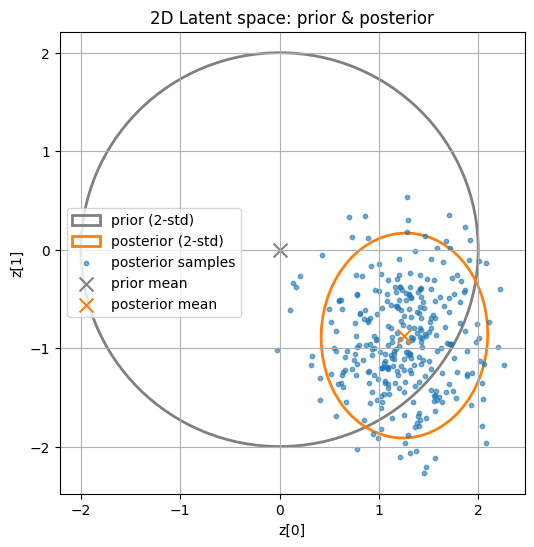

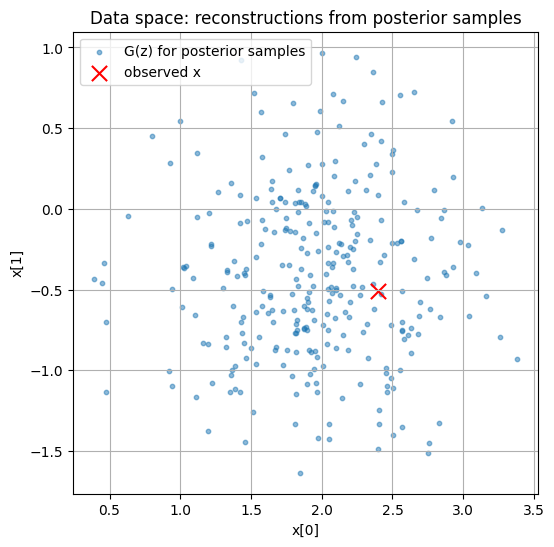

In [2]:
# Cell 3 — 2D latent: compute posterior step-by-step, print, and visualize
# Run after Cell 2

print("=== 2D Latent Example: analytic posterior (step-by-step) ===")

# dims
d_x, d_z = 2, 2

# model params (toy)
W = np.array([[1.2, -0.4],
              [0.5,  0.9]])   # shape (d_x, d_z)
b = np.array([0.1, -0.2])
sigma = 0.6

print("\nModel parameters:")
print("W =\n", W)
print("b =", b)
print("sigma =", sigma)

# Step 1: compute W^T W
WtW = W.T @ W
print("\nW^T W =\n", WtW)

# Step 2: posterior covariance Sigma_post = (I + (1/sigma^2) W^T W)^{-1}
I_z = np.eye(d_z)
Sigma_post = np.linalg.inv(I_z + (1.0/(sigma**2)) * WtW)
print("\nPosterior covariance Sigma_post =\n", Sigma_post)

# Step 3: choose a true latent and generate noisy x
z_true = np.array([0.7, -1.0])
x_obs = W @ z_true + b + np.random.normal(scale=sigma, size=d_x)
print("\nChosen z_true =", z_true)
print("Generated observation x_obs =", x_obs)

# Step 4: compute posterior mean mu_post = Sigma_post * (1/sigma^2) * W^T (x - b)
residual = x_obs - b
print("\nResidual (x_obs - b) =", residual)
mu_post = Sigma_post @ ((1.0/(sigma**2)) * (W.T @ residual))
print("\nPosterior mean mu_post =\n", mu_post)

# Step 5: eigenvalues (variances along principal axes)
eigvals, eigvecs = np.linalg.eigh(Sigma_post)
print("\nPosterior eigenvalues (variances) =", eigvals)

# Step 6: sample from posterior and plot latent space
n_samples = 300
z_samples = np.random.multivariate_normal(mean=mu_post, cov=Sigma_post, size=n_samples)

fig, ax = plt.subplots(figsize=(6,6))
plot_cov_ellipse(ax, mu=np.zeros(d_z), cov=np.eye(d_z), nstd=2, edgecolor='gray', label='prior (2-std)')
plot_cov_ellipse(ax, mu=mu_post, cov=Sigma_post, nstd=2, edgecolor='C1', label='posterior (2-std)')
ax.scatter(z_samples[:,0], z_samples[:,1], s=10, alpha=0.6, label='posterior samples')
ax.scatter(0,0, marker='x', s=100, color='gray', label='prior mean')
ax.scatter(mu_post[0], mu_post[1], marker='x', s=100, color='C1', label='posterior mean')
ax.set_xlabel('z[0]'); ax.set_ylabel('z[1]')
ax.set_title('2D Latent space: prior & posterior')
ax.legend(); ax.grid(True)
plt.show()

# Step 7: push posterior samples through generative map to data space and plot
x_from_post = (W @ z_samples.T).T + b
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x_from_post[:,0], x_from_post[:,1], s=10, alpha=0.5, label='G(z) for posterior samples')
ax.scatter(x_obs[0], x_obs[1], marker='x', s=120, color='red', label='observed x')
ax.set_title('Data space: reconstructions from posterior samples')
ax.set_xlabel('x[0]'); ax.set_ylabel('x[1]')
ax.legend(); ax.grid(True)
plt.show()


=== 3D Latent Example: analytic posterior (step-by-step) ===

W3 =
 [[ 1.   0.2 -0.3]
 [ 0.4  0.9  0.1]
 [-0.2  0.5  0.8]]
b3 = [ 0.   0.1 -0.1]
sigma3 = 0.7

Posterior covariance Sigma_post_3 =
 [[ 0.37960832 -0.16000658  0.18555961]
 [-0.16000658  0.40779812 -0.19719996]
 [ 0.18555961 -0.19719996  0.53067563]]

z_true3 = [ 0.5 -0.6  0.8]
x_obs3 = [-0.52105794  0.0066722  -0.84417404]

Posterior mean mu_post_3 = [-0.30411438 -0.15212203 -0.41517902]

Posterior eigenvalues: [0.23288461 0.27167346 0.813524  ]


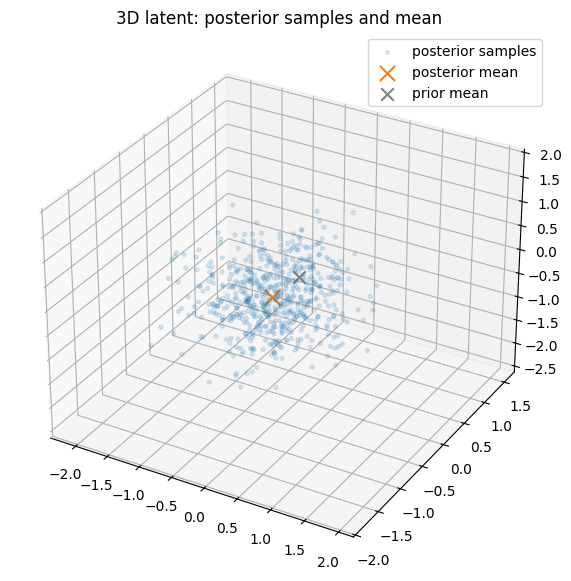

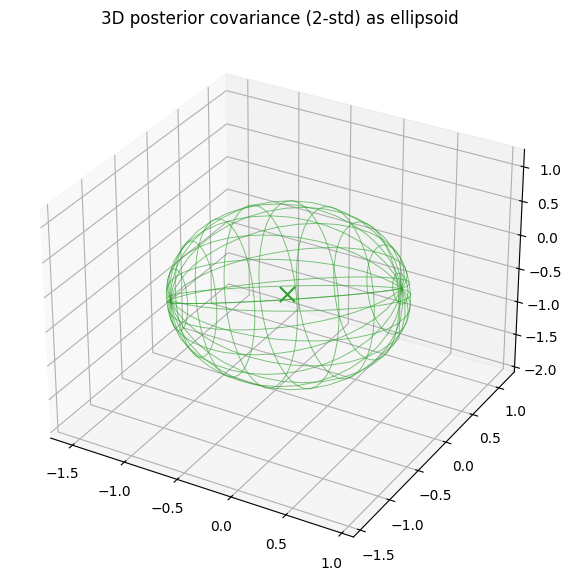

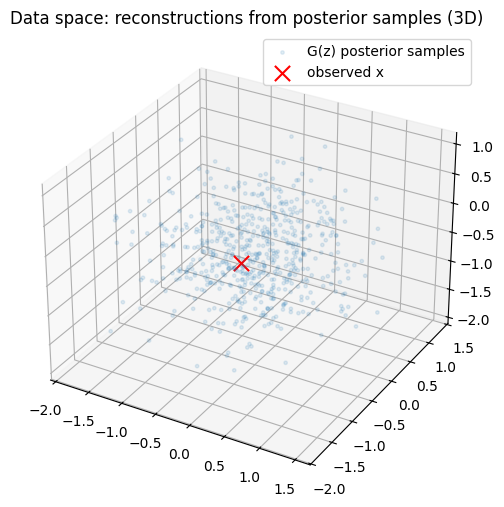

In [3]:
# Cell 4 — 3D latent: analytic posterior and 3D visualizations
# Run after Cell 3

print("=== 3D Latent Example: analytic posterior (step-by-step) ===")

# dims
d_x3, d_z3 = 3, 3

# toy params
W3 = np.array([[1.0, 0.2, -0.3],
               [0.4, 0.9,  0.1],
               [-0.2, 0.5, 0.8]])
b3 = np.array([0.0, 0.1, -0.1])
sigma3 = 0.7

print("\nW3 =\n", W3)
print("b3 =", b3)
print("sigma3 =", sigma3)

# compute posterior covariance
Sigma_post_3 = np.linalg.inv(np.eye(d_z3) + (1.0/(sigma3**2)) * (W3.T @ W3))
print("\nPosterior covariance Sigma_post_3 =\n", Sigma_post_3)

# pick z_true and generate x_obs
z_true3 = np.array([0.5, -0.6, 0.8])
x_obs3 = W3 @ z_true3 + b3 + np.random.normal(scale=sigma3, size=d_x3)
print("\nz_true3 =", z_true3)
print("x_obs3 =", x_obs3)

# posterior mean
mu_post_3 = Sigma_post_3 @ ((1.0/(sigma3**2)) * (W3.T @ (x_obs3 - b3)))
print("\nPosterior mean mu_post_3 =", mu_post_3)

# eigenvalues for uncertainty interpretation
eigvals3, eigvecs3 = np.linalg.eigh(Sigma_post_3)
print("\nPosterior eigenvalues:", eigvals3)

# sample and plot posterior in 3D latent space
n3 = 600
z_samples3 = np.random.multivariate_normal(mean=mu_post_3, cov=Sigma_post_3, size=n3)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_samples3[:,0], z_samples3[:,1], z_samples3[:,2], s=8, alpha=0.15, label='posterior samples')
ax.scatter(mu_post_3[0], mu_post_3[1], mu_post_3[2], marker='x', s=120, color='C1', label='posterior mean')
ax.scatter(0,0,0, marker='x', s=80, color='gray', label='prior mean')
ax.set_title('3D latent: posterior samples and mean'); ax.legend()
plt.show()

# 3D ellipsoid wireframe
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
plot_cov_ellipsoid_wireframe(ax, mu_post_3, Sigma_post_3, nstd=2.0, color='C2', alpha=0.6)
ax.scatter(mu_post_3[0], mu_post_3[1], mu_post_3[2], marker='x', s=120, color='C2', label='posterior mean')
ax.set_title('3D posterior covariance (2-std) as ellipsoid')
plt.show()

# project posterior samples to data space and plot
x_rec3 = (W3 @ z_samples3.T).T + b3
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_rec3[:,0], x_rec3[:,1], x_rec3[:,2], s=6, alpha=0.12, label='G(z) posterior samples')
ax.scatter(x_obs3[0], x_obs3[1], x_obs3[2], marker='x', s=120, color='red', label='observed x')
ax.set_title('Data space: reconstructions from posterior samples (3D)')
ax.legend(); plt.show()


=== Amortized inference: training a simple encoder (LinearRegression) ===
Trained linear encoder: coef shape (2, 2)  intercept [-0.00733783  0.16524802]
MSE between encoder predictions and analytic posterior mean (test): 1.2303589917250714e-31


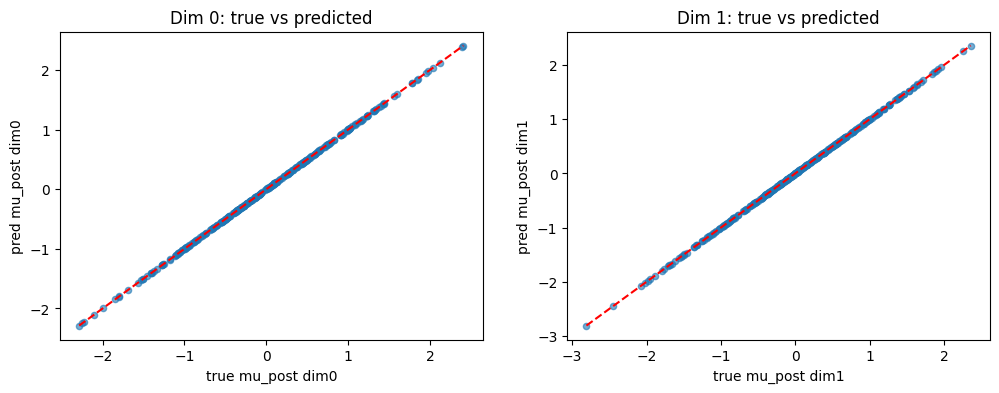

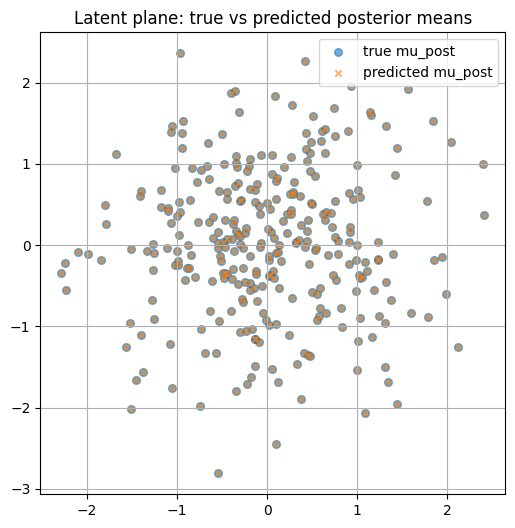

In [4]:
# Cell 5 — Train a small encoder (linear regression) to predict mu_post from x and evaluate
# Run after Cell 4

print("=== Amortized inference: training a simple encoder (LinearRegression) ===")

# We'll use the 2D model parameters W, b, sigma from Cell 3
# Generate dataset of (x, analytic mu_post) pairs
d_z = 2
n_train = 2000
Z_train = np.random.multivariate_normal(mean=np.zeros(d_z), cov=np.eye(d_z), size=n_train)
X_train = (W @ Z_train.T).T + b + np.random.normal(scale=sigma, size=(n_train, 2))

Sigma_post_enc = np.linalg.inv(np.eye(d_z) + (1.0/(sigma**2)) * (W.T @ W))
mu_posts = np.array([Sigma_post_enc @ ((1.0/(sigma**2)) * (W.T @ (X_train[i] - b))) for i in range(n_train)])

# Train encoder
reg = LinearRegression().fit(X_train, mu_posts)
print("Trained linear encoder: coef shape", reg.coef_.shape, " intercept", reg.intercept_)

# Test on held-out set
n_test = 300
Z_test = np.random.multivariate_normal(mean=np.zeros(d_z), cov=np.eye(d_z), size=n_test)
X_test = (W @ Z_test.T).T + b + np.random.normal(scale=sigma, size=(n_test, 2))
mu_test_true = np.array([Sigma_post_enc @ ((1.0/(sigma**2)) * (W.T @ (X_test[i] - b))) for i in range(n_test)])
mu_test_pred = reg.predict(X_test)

mse = np.mean((mu_test_true - mu_test_pred)**2)
print("MSE between encoder predictions and analytic posterior mean (test):", mse)

# scatter plots: true vs predicted for each latent dim
fig, axes = plt.subplots(1, d_z, figsize=(12,4))
for dim in range(d_z):
    ax = axes[dim]
    ax.scatter(mu_test_true[:,dim], mu_test_pred[:,dim], s=20, alpha=0.6)
    mins = min(mu_test_true[:,dim].min(), mu_test_pred[:,dim].min())
    maxs = max(mu_test_true[:,dim].max(), mu_test_pred[:,dim].max())
    ax.plot([mins, maxs], [mins, maxs], 'r--')
    ax.set_xlabel(f"true mu_post dim{dim}"); ax.set_ylabel(f"pred mu_post dim{dim}")
    ax.set_title(f"Dim {dim}: true vs predicted")
plt.show()

# plot in latent plane: true vs predicted means
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(mu_test_true[:,0], mu_test_true[:,1], s=30, alpha=0.6, label='true mu_post')
ax.scatter(mu_test_pred[:,0], mu_test_pred[:,1], s=20, alpha=0.6, marker='x', label='predicted mu_post')
ax.set_title('Latent plane: true vs predicted posterior means'); ax.legend(); ax.grid(True)
plt.show()


=== Effect of observation noise sigma on posterior uncertainty ===


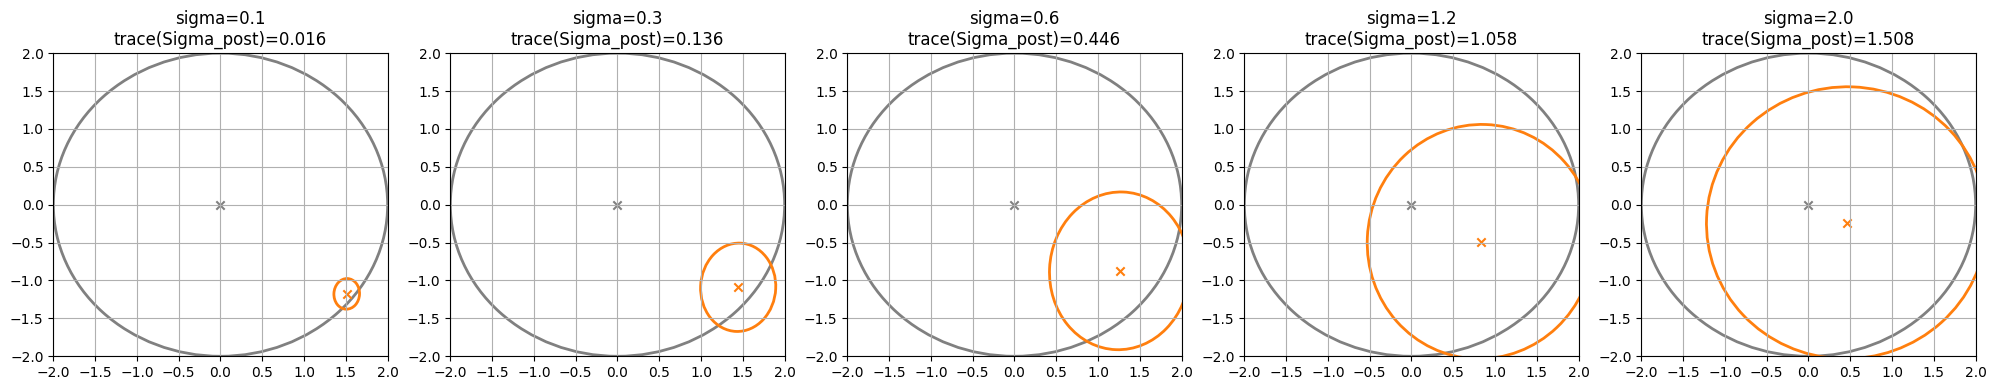

In [5]:
# Cell 6 — Inspect effect of observation noise sigma on posterior covariance (2D)
# Run after Cell 5

print("=== Effect of observation noise sigma on posterior uncertainty ===")

sigmas = [0.1, 0.3, 0.6, 1.2, 2.0]
fig, axes = plt.subplots(1, len(sigmas), figsize=(4*len(sigmas), 4))
for i, s in enumerate(sigmas):
    Sigma_s = np.linalg.inv(np.eye(2) + (1.0/(s**2)) * (W.T @ W))
    mu_s = Sigma_s @ ((1.0/(s**2)) * (W.T @ (x_obs - b)))  # use same x_obs from Cell 3
    ax = axes[i]
    plot_cov_ellipse(ax, mu=np.zeros(2), cov=np.eye(2), nstd=2, edgecolor='gray')
    plot_cov_ellipse(ax, mu=mu_s, cov=Sigma_s, nstd=2, edgecolor='C1')
    ax.scatter(0,0, marker='x', color='gray')
    ax.scatter(mu_s[0], mu_s[1], marker='x', color='C1')
    ax.set_title(f"sigma={s}\ntrace(Sigma_post)={np.trace(Sigma_s):.3f}")
    ax.set_xlim(-2,2); ax.set_ylim(-2,2); ax.grid(True)
plt.tight_layout(); plt.show()


# Summary & Next Steps

**What we covered (all with $...$ math):**
- Derived closed-form posterior for linear-Gaussian:
  $ \Sigma_{\text{post}} = \left(I + \frac{1}{\sigma^2} W^\top W \right)^{-1} $ and
  $ \mu_{\text{post}} = \Sigma_{\text{post}} \frac{1}{\sigma^2} W^\top (x - b) $.
- Printed intermediate matrices and eigenvalues so you can *see* how uncertainty is allocated.
- Visualized prior vs posterior in 2D and 3D (ellipses, ellipsoids, samples).
- Demonstrated amortized inference by training a simple encoder and comparing it to analytic posterior.
- Explored effect of noise level $ \sigma $ on posterior shrinkage.

**Practical tips:**
- For nonlinear $G$, posterior is not closed-form → use MAP optimization, variational inference, or amortized inference.
- Visualize posterior means and covariances to gain intuition about uncertainty.
- Use many samples when estimating empirical covariances; numerical stabilization (small diagonal $ \varepsilon I $) sometimes needed.

**Want next:** I can
- produce a downloadable `.ipynb` with these cells, or
- replace linear $G$ with a small CNN and show approximate MAP inversion on images, or
- add animations showing posterior shrink as $ \sigma \to 0 $.

Tell me which follow-up you want and I will produce it.
